# Problem Set #12

**Tc2037 Implementation of Computational Methods**

April 22, 2021.

_Authors of this notebook’s solution:_

- _Student ID and Name:_
- _Student ID and Name:_

**Instructions:** Follow the indications contained in this notebook. Complete the code where required.

In [1]:
;; External function required for this notebook.
(require '[clojure.test :refer [is]])

nil

## Non-deterministic Finite Automata with $\varepsilon$-Transitions ($\varepsilon$-NFA)

A non-deterministic finite automaton with $\varepsilon$-transitions ($\varepsilon$-NFA) extends the class of NFAs by allowing instantaneous ($\varepsilon$) transitions: 

* An automaton may be allowed to change its state without reading the input symbol.
* In state diagrams, these transitions are depicted by labeling the appropriate arcs with $\varepsilon$.

**NOTE:** This does not mean that $\varepsilon$ has become an input symbol. On the contrary, we assume that the symbol $\varepsilon$ does not belong to any alphabet.

$\epsilon$-transitions provide a convenient way of modeling systems whose current states are not precisely known: i.e., if we are modeling a system and it is not clear whether the current state (after processing some input string) should be $q_i$ or $q_j$, then we can add an $\varepsilon$-transition between these two states, thus putting the automaton in both states simultaneously.

A $\epsilon$-NFA can de represented by a _state diagram_ or by the 5-tuple $(Q, \Sigma, \delta, q_0, F)$:

* $Q$ is a finite set of states.  
* $\Sigma$ is a finite set of symbols, called the _alphabet_ of the automaton.
* $\delta$ is the transition function: $Q \times (\Sigma \cup \{ \varepsilon \}) \to \mathcal{P}(Q)$, where $\mathcal{P}(Q)$ is the power set of $Q$.
* $q_0$ is the initial state from where any input is processed ($q_0 \in Q$).
* $F$ is a set of final states ($F \subseteq  Q$). 

### $\varepsilon$-NFA Example

We want a machine that accepts strings of `a`s whose length is a multiple of two or three.

This state diagram of a $\varepsilon$-NFA achieves this:

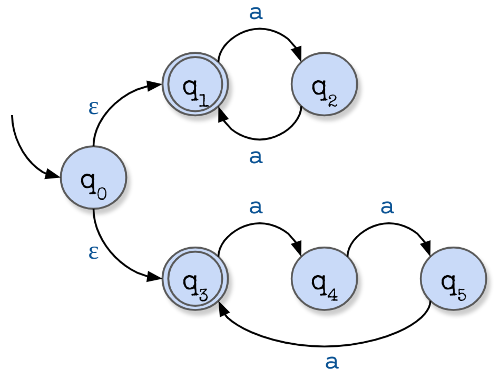

Thus, the formal definition of the NFA is as follows:

* $Q = \{ q_0, q_1, q_2, q_3, q_4, q_5 \}$   
* $\Sigma = \{ a \}$
* $q_0 =$ Initial state
* $F = \{ q_1, q_3 \}$
* This table shows the transition function $\delta$:

| Current State | Next state with $\varepsilon$ | Next state for input $a$ |
|:-------------:|:-----------------------------:|:------------------------:|
|     $q_0$     |           $q_1, q_3$          |                          |
|     $q_1$     |                               |           $q_2$          |
|     $q_2$     |                               |           $q_1$          |
|     $q_3$     |                               |           $q_4$          |
|     $q_4$     |                               |           $q_5$          |
|     $q_5$     |                               |           $q_3$          |

### Exercise 1

Design a $\varepsilon$-NFA with $\Sigma = \{ x, y, z \}$ that accepts any of the following:

* The string ‘$xyz$’.
* Strings that end with ‘$zzz$’.
* Strings that contain an odd number of ‘$y$’s.

Your solution must include the state diagram and the formal definition.

## $\varepsilon$-NFA Simulation

We need the code we defined before for the simultation of DFAs and NFAs. 

In [2]:
(defrecord Rule [state character next-state])

(defrecord NFA [current-states accept-states rulebook])

(defn applies-to?
  [rule state character]
  (and (= (:state rule) state)
       (= (:character rule) character)))

(defn follow
  [rule]
  (:next-state rule))

(defn rules-for
  [rulebook state character]
  (filter #(applies-to? % state character) rulebook))

(defn follow-rules-for
  [rulebook state character]
  (map follow (rules-for rulebook state character)))

(defn next-states
  [rulebook states character]
  (set (mapcat #(follow-rules-for rulebook % character) states)))

(defn current-states
  [nfa]
  (:current-states nfa))

(defn accepting?
  [nfa]
  (not (empty? (clojure.set/intersection (current-states nfa)
                                         (:accept-states nfa)))))

(defn process-character
  [nfa character]
  (assoc nfa
         :current-states
         (next-states (:rulebook nfa)
                      (current-states nfa)
                      character)))

(defn accepts?
  [nfa input]
  (if (empty? input)
    (accepting? nfa)
    (recur (process-character nfa (first input))
           (rest input))))

#'user/accepts?

Just like before, we will have a _rulebook_, a vector of `Rule` objects, that represents the transition function for our $\varepsilon$-NFAs. For the previous $\varepsilon$-NFA example it would look like this:

In [3]:
(def rb-example1 [(->Rule 0 nil 1) 
                  (->Rule 0 nil 3) 
                  (->Rule 1 \a 2)
                  (->Rule 2 \a 1) 
                  (->Rule 3 \a 4)
                  (->Rule 4 \a 5) 
                  (->Rule 5 \a 3)])

#'user/rb-example1

We will be using Clojure’s `nil` object to represent $\varepsilon$ in our code.

In [4]:
(is (= #{1 3} (next-states rb-example1 #{0} nil)))
(is (= #{} (next-states rb-example1 #{5} nil)))

true

The `follow-epsilon-transitions` function will help us find all the states that can be reached by following $\varepsilon$-transitions from a particular set of states. This code  will have to follow free moves repeatedly, because an NFA can spontaneously change states as  many times as it likes as long as there are $\varepsilon$-transitions leading from its current state.

In [5]:
(defn follow-epsilon-transitions
  [rulebook states]
  (let [more-states (next-states rulebook states nil)]
    (if (clojure.set/subset? more-states states)
      states
      (recur rulebook (clojure.set/union states more-states)))))

#'user/follow-epsilon-transitions

In [6]:
(is (= #{0 1 3} (follow-epsilon-transitions rb-example1 #{0})))
(is (= #{5} (follow-epsilon-transitions rb-example1 #{5})))

true

Now we introduce this $\varepsilon$-transition support into the NFA code by rewriting the  existing implementation of the `current-states` function. The new implementation will hook into the `follow-epsilon-transitions` function and ensure that the possible current states of the automaton always include any states that are reachable via $\varepsilon$-transitions:

In [7]:
(defn current-states
  [nfa]
  (follow-epsilon-transitions (:rulebook nfa) (:current-states nfa)))

#'user/current-states

It is possible now to use the `accepts?` function to verify everything is working as expected.

In [8]:
(let [nfa (->NFA #{0} #{1 3} rb-example1)]
  (is (accepts? nfa ""))
  (is (accepts? nfa "aa"))
  (is (accepts? nfa "aaa"))
  (is (accepts? nfa "aaaa"))
  (is (accepts? nfa "aaaaaa"))
  (is (accepts? nfa "aaaaaaaaaaaa"))
  (is (not (accepts? nfa "a")))
  (is (not (accepts? nfa "aaaaa")))
  (is (not (accepts? nfa "aaaaaaa")))
  (is (not (accepts? nfa "aaaaaaaaaaa"))))

true

### Exercise 2

Simulate in code the $\varepsilon$-NFA you designed for exercise 1 and write unit tests that check the following strings:

1. Accepts: $xyz$
2. Accepts: $zzz$
3. Accepts: $y$
4. Accepts: $zyx$
5. Accepts: $xyzxyzxyz$
6. Accepts: $xyzxyzzz$
7. Rejects: $\varepsilon$
8. Rejects: $x$
9. Rejects: $xxyyzz$
10. Rejects: $yy$
11. Rejects: $xxxxxxx$
12. Rejects: $zzzyyyyyyxxx$

In [9]:
;;; your unit tests go here